# Jupyter notebook to set up VI inversion

This notebook prepares the input data and sets up the VI inversion for the academic inversion code JIF3D developed by **Max Moorkamp et al.** https://sourceforge.net/projects/jif3d/. <br>


This notebook reads in gravity and magnetic measurements with the associated station heights, bedrock topography, Curie point depths and Moho depth. The data is transferred into SI units except for the magnetic data. The coordinates are shifted to positive values, as required by JIF3D and the z axis is defined to be positive downwards. Additionally, this notebook prepares the inversion model (mesh) for both the gravity and magnetic model with a 20 % padding around the measured input data. The prepared input data and inversion mesh’s are stored in NetCDF's files, which are used by JIF3D. Finally, this notebook creates a Linux shell script, which calls the inversion code and passes the required information of the NetCDF files. <br>

**jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 15/05/2023**


#### Import python libariers

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from cmcrameri import cm   
import os
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging


#### Load data

In [2]:
residual_grav_pd = pd.read_csv('DATA/Residual_grav_reso_10km_stationheight_10km_mean_removed.txt', skiprows=1, 
                        names=['x_ps' , 'y_ps' , 'resi_grav'])

Mag_data_pd = pd.read_csv('DATA/ADMAP_reso_10km_stationheight_10km.txt', skiprows=0, 
                       names=['x_ps' , 'y_ps' , 'Mag'])

Bedrock_data_pd = pd.read_csv('DATA/bed_rock_topo_JIF3D_20_procent_padding_5km_reso.txt' , skiprows=1, 
                        names=['x_ps' , 'y_ps' , 'Bedrock' ])

Moho_data_pd = pd.read_csv('DATA/Moho_Pappa_JIF3D_20_procent_padding_7500km_reso.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'Moho' ])

CDP_lowe_pd = pd.read_csv('DATA/CDP_GHF_300km_window_TAM_WSB_Lowe.csv', skiprows=0)

Coastline = pd.read_pickle('DATA/costline_wsb.pkl')


# Prepare Data:

#### create export path for data products

In [3]:
Inversion_run = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_25e3_run1'

# Create path if it does not exists
if not os.path.exists(Inversion_run):
    os.makedirs(Inversion_run)
    
inversion_path = Inversion_run + '/VI_inversion/'

# Create path if it does not exists
if not os.path.exists(inversion_path):
    os.makedirs(inversion_path)

#### Gravity data

In [4]:
# transfer panda dataframe to numpy arrays
Grav_data = residual_grav_pd.to_numpy()

# define coordinates and data values
grav_x = Grav_data[:,0]
grav_y = Grav_data[:,1]
grav_BA = Grav_data[:,2]
grav_z = np.zeros(len(grav_x))
grav_MeasZ = grav_z -10000  # model geometry is defined as postive = down


## convert gravity data from mGal to SI unit
grav_BA_si = grav_BA * 1e-5

#set a global gravity error of 10^-5 m/s2
grav_BA_si_sigma = np.ones(grav_BA_si.shape) * 1e-5


#### Check extension of gravity data

In [5]:
# recover extenstion of imported data
grav_x_max = max(grav_x)
grav_x_min = min(grav_x)
grav_y_max = max(grav_y)
grav_y_min = min(grav_y)

# print data extentsion
print(" grav x min: " , grav_x_min , "m \n" , "grav x max: " , grav_x_max , "m \n" , "grav y min:" , grav_y_min , "m \n" ,
     "grav y min:" , grav_y_max , "m \n")

 grav x min:  280000.00004849 m 
 grav x max:  1590000.00004849 m 
 grav y min: -2153929.85173213 m 
 grav y min: -1403929.85173213 m 



#### Magnetic data

In [6]:
# transfer panda dataframe to numpy arrays
Mag_data = Mag_data_pd.to_numpy()

# define coordinates and data values
mag_x = Mag_data[:,0]
mag_y = Mag_data[:,1]
mag_T = Mag_data[:,2]
mag_z = np.zeros(len(mag_x))
mag_MeasZ = mag_z -10000  # model geometry is defined as postive = down

#set data error to 1 nT 
mag_T_sigma = np.ones(mag_T.shape)


#### Check extension of magnetic data

In [7]:
# recover extenstion of imported data
mag_x_max = max(mag_x)
mag_x_min = min(mag_x)
mag_y_max = max(mag_y)
mag_y_min = min(mag_y)

# print data extentsion
print(" mag x min: " , mag_x_min , "m \n" , "mag x max: " , mag_x_max , "m \n" , "mag y min:" , mag_y_min , "m \n" ,
     "mag y min:" , mag_y_max , "m \n")

 mag x min:  277000.0 m 
 mag x max:  1607000.0 m 
 mag y min: -2179500.0 m 
 mag y min: -1399500.0 m 



#### Bedrock topography and ice surface

In [8]:
# transfer panda dataframe to numpy arrays
Bedrock_data = Bedrock_data_pd.to_numpy()

# define coordinates and data values
Bedrock_x = Bedrock_data[:,0]
Bedrock_y = Bedrock_data[:,1]
Bedrock_z_ix = Bedrock_data[:,2]

# invert topography values (modele geometry is defined as postive = down)
Bedrock_z = Bedrock_z_ix *-1

#### Moho and CDP data

In [9]:
# transfer panda dataframe to numpy arrays
Moho_data = Moho_data_pd.to_numpy()

# define coordinates and data values
Moho_x = Moho_data[:,0]
Moho_y = Moho_data[:,1]
Moho_z_ix = np.round(Moho_data[:,2] , decimals=1)

Moho_z = Moho_z_ix *1000  #  convert from km to m

CDP_lowe = CDP_lowe_pd.to_numpy()

CDP_x = CDP_lowe[:,3]
CDP_y = CDP_lowe[:,4]
CDP_z_ix = CDP_lowe[:,5]
CDP_z = CDP_z_ix *1000  #  convert from km to m

## Shift data

#### define coordinate shift since the inversion requires a positive coordinates only!

In [10]:
# define value to shift the coordinates of the data sets
x_shift = abs(grav_x_min)
y_shift = abs(grav_y_min)

# shifting data by twice the smallest x and y value 
grav_x_shifted = grav_x + (2*x_shift)
grav_y_shifted = grav_y + (2*y_shift)

# shifting data by twice the smallest x and y value 
mag_x_shifted = mag_x + (2*x_shift)
mag_y_shifted = mag_y + (2*y_shift)

# shifting data by twice the smallest x and y value 
Bedrock_x_shifted = Bedrock_x + (2*x_shift)
Bedrock_y_shifted = Bedrock_y + (2*y_shift)

# shifting data by twice the smallest x and y value
Moho_x_shifted = Moho_x + (2*x_shift)
Moho_y_shifted = Moho_y + (2*y_shift)

# shifting data by twice the smallest x and y value
CDP_x_shifted = CDP_x + (2*x_shift)
CDP_y_shifted = CDP_y + (2*y_shift)

In [11]:
export_shift_value =  np.vstack((x_shift , y_shift)).T

np.savetxt('DATA/exported_shift_value.txt', export_shift_value, delimiter=',' , header='x,y')

#### Shifted datasets

In [12]:
topo_data = np.vstack((Bedrock_x_shifted , Bedrock_y_shifted , Bedrock_z)).T
Moho = np.vstack((Moho_x_shifted , Moho_y_shifted , Moho_z)).T
CDP = np.vstack((CDP_x_shifted , CDP_y_shifted , CDP_z)).T

#### find max min data points of the shifted dataset

In [13]:
# max min gravity data
grav_x_min_shifted = min(grav_x_shifted) 
grav_x_max_shifted = max(grav_x_shifted) 
grav_y_min_shifted = min(grav_y_shifted)  
grav_y_max_shifted = max(grav_y_shifted)

print(grav_x_min_shifted)
print(grav_x_max_shifted)
print(grav_y_min_shifted)
print(grav_y_max_shifted)

840000.00014547
2150000.00014547
2153929.85173213
2903929.85173213


In [14]:
# max min mag data
mag_x_min_shifted = min(mag_x_shifted) 
mag_x_max_shifted = max(mag_x_shifted) 
mag_y_min_shifted = min(mag_y_shifted)  
mag_y_max_shifted = max(mag_y_shifted)

print(mag_x_min_shifted)
print(mag_x_max_shifted)
print(mag_y_min_shifted)
print(mag_y_max_shifted)

837000.00009698
2167000.00009698
2128359.7034642603
2908359.7034642603


### plot input datasets

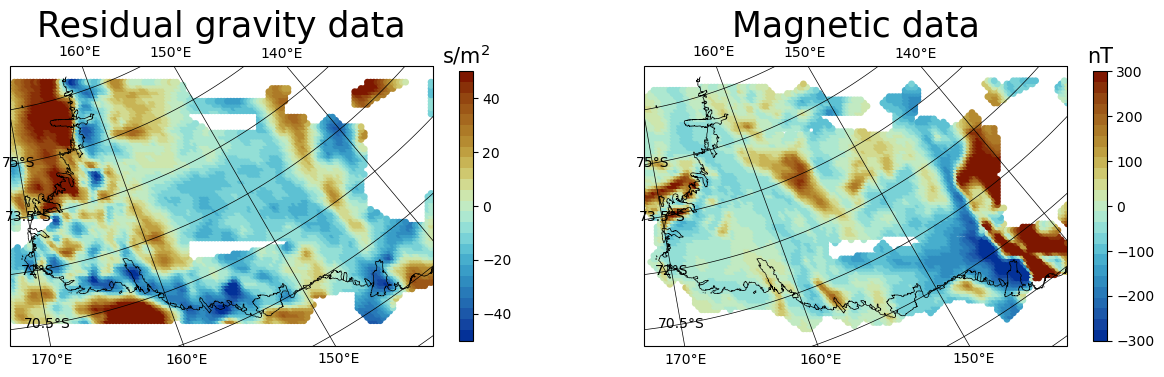

In [15]:
# define colormap
cmap_rev = cm.roma_r.resampled(25)
cmap = cm.roma.resampled(25)
cmap_bedrock = cm.roma.resampled(25)
cmap_ice = cm.roma.resampled(25)

symbol_size = 15

# create figure
figure1 = plt.figure(figsize=(15,10),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title('Residual gravity data',fontsize=25)
im1 = plt.scatter(grav_x_shifted-(2*x_shift), grav_y_shifted-(2*y_shift) , symbol_size , c=grav_BA_si / 1e-5 , cmap = cmap_rev ,
                 vmin = -50 , vmax = 50)
ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.35)
cb.ax.set_title("s/m$^{2}$",fontsize=15)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)


# subplot Magnetic data
ax2 = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
plt.title('Magnetic data',fontsize=25)
im2 = plt.scatter(mag_x_shifted - (2*x_shift) , mag_y_shifted-(2*y_shift) , symbol_size , c=mag_T , cmap = cmap_rev , vmin = -300 , vmax = 300)
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax2 , color = 'k' , linewidth = 0.5)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im2, shrink=.35)
cb.ax.set_title("nT",fontsize=15)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)


Text(0.5, 1.0, 'm')

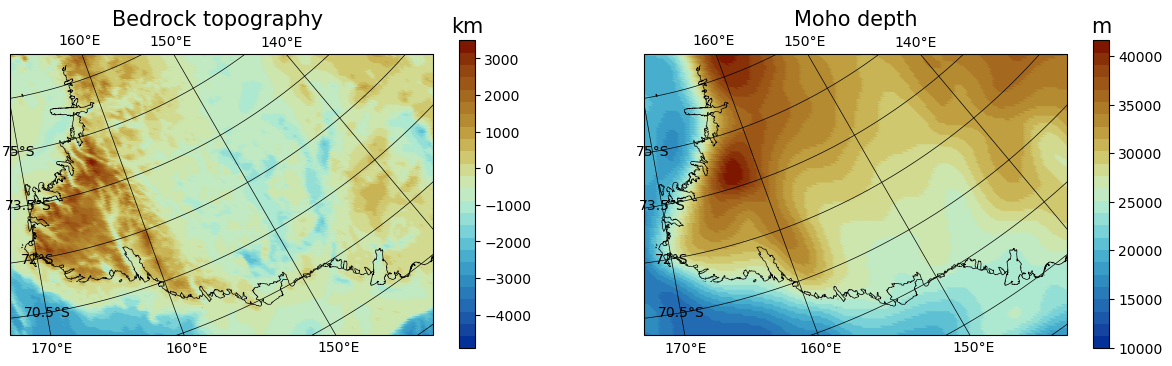

In [16]:
# create figure
figure1 = plt.figure(figsize=(15,10),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title('Bedrock topography ',fontsize=15)
im1 = plt.scatter(Bedrock_x_shifted-(2*x_shift),Bedrock_y_shifted-(2*y_shift),c=Bedrock_z_ix , cmap = cmap_rev)
ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
# axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=.4)
cb.ax.set_title("km",fontsize=15)


# subplot Magnetic data
ax2 = plt.subplot(1, 2, 2 , projection=ccrs.SouthPolarStereo())
plt.title('Moho depth',fontsize=15)
im2 = plt.scatter(Moho_x_shifted-(2*x_shift),Moho_y_shifted-(2*y_shift),c=Moho_z , cmap = cmap_rev)
ax2.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax2 , color = 'k' , linewidth = 0.5)
ax2.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im2, shrink=.4)
cb.ax.set_title("m",fontsize=15)

Text(0.5, 1.0, 'm')

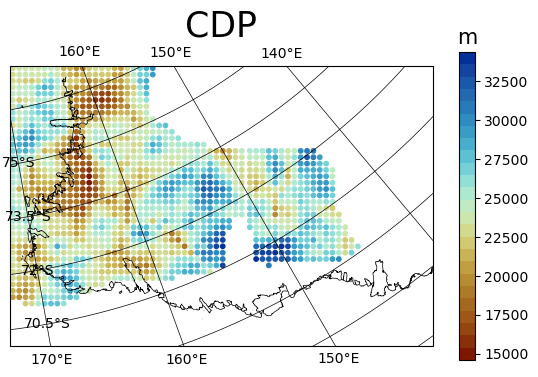

In [17]:
# create figure
figure1 = plt.figure(figsize=(15,10),facecolor='white')

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1 , projection=ccrs.SouthPolarStereo())
plt.title('CDP',fontsize=25)
im1 = plt.scatter(CDP[:,0]-(2*x_shift),CDP[:,1]-(2*y_shift), 10, c=CDP[:,2] , cmap = cmap)
ax1.set_extent([172 , 135 , -73, -70], ccrs.PlateCarree())
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im1, shrink=.4)
cb.ax.set_title("m",fontsize=15)

# Build Data NetCDF file for gravity and magnetic respectivily

#### Define rectangular boundary for measurments

In [18]:
# define boundary for the gravity data
ind_grav = (grav_x_shifted > mag_x_min_shifted) & (grav_x_shifted < mag_x_max_shifted) & (grav_y_shifted > mag_y_min_shifted) & (grav_y_shifted < mag_y_max_shifted)

### Gravity NetCDF file:

In [19]:
# define name of the NetCDF file
grav_data_file = Dataset(inversion_path + "gravdata.nc", "w")

# The number of stations within the bounds specified above
nstat = grav_x_shifted[ind_grav].size

#create a dimension with the corret number of stations
statdim = grav_data_file.createDimension("StationNumber", nstat)


## x coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasx = grav_data_file.createVariable("MeasPosX","f8",("StationNumber"))
#set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
# fill the variable
vmeasx[:] = grav_x_shifted[ind_grav]

## y coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasy = grav_data_file.createVariable("MeasPosY","f8",("StationNumber"))
#set the units metadata entry for the variable MeasPosY
vmeasy.units = "m"
# fill the variable
vmeasy[:] = grav_y_shifted[ind_grav]

## z coordinates (station height)
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasz = grav_data_file.createVariable("MeasPosZ","f8",("StationNumber"))
#set the units metadata entry for the variable MeasPosZ
vmeasz.units = "m"
# fill the variable
vmeasz[:] = grav_MeasZ[ind_grav]

## BA gravity values
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vgz = grav_data_file.createVariable("Scalar_gravity","f8",("StationNumber"))
#set the units metadata entry for the variable Scalar_gravity
vgz.units = "m/s2"
# fill the variable
vgz[:] = grav_BA_si[ind_grav]

## BA gravity uncertainty value
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vdgz = grav_data_file.createVariable("dGz","f8",("StationNumber"))
#set the units metadata entry for the variable dGz
vdgz.units = "m/s2"
# fill the variable
vdgz[:] = grav_BA_si_sigma[ind_grav]

#close the file
grav_data_file.close()

### Magnetic data

#### Define rectangular boundary for magnetic measurments equal to the gravity boundary 

In [20]:
#determine the indices in our magnetic dataset that fall into the box
ind_mag = (mag_x_shifted > mag_x_min_shifted) & (mag_x_shifted <  mag_x_max_shifted) & (mag_y_shifted > mag_y_min_shifted) & (mag_y_shifted < mag_y_max_shifted)

### Magnetic NetCDF file:

In [21]:
#write netCDF file following the same approach as the gravity data
mag_data_file = Dataset(inversion_path + "magdata.nc", "w")
nstat = mag_x_shifted[ind_mag].size

statdim = mag_data_file.createDimension("StationNumber", nstat)
vmeasx = mag_data_file.createVariable("MeasPosX","f8",("StationNumber"))
vmeasx.units = "m"
vmeasx[:] = mag_x_shifted[ind_mag]

vmeasy = mag_data_file.createVariable("MeasPosY","f8",("StationNumber"))
vmeasy.units = "m"
vmeasy[:] = mag_y_shifted[ind_mag]
vmeasz = mag_data_file.createVariable("MeasPosZ","f8",("StationNumber"))
vmeasz.units = "m"
vmeasz[:] = mag_MeasZ[ind_mag]

vgz = mag_data_file.createVariable("T","f8",("StationNumber"))
vgz.units = "nT"
vgz[:] = mag_T[ind_mag]
vdgz = mag_data_file.createVariable("dT","f8",("StationNumber"))
vdgz.units = "nT"

vdgz[:] = mag_T_sigma[ind_mag]
mag_data_file.close()

# Prepare inversion model:

In [22]:
# set mesh resolution
model_res = 7500

# check x and y model data extension
data_extension_x = grav_x_max_shifted - grav_x_min_shifted
data_extension_y = grav_y_max_shifted - grav_y_min_shifted

# calculate 20 procent padding around the meassured data points
padding_x = (data_extension_x * 20)/100
padding_y = (data_extension_y * 20)/100

# add padding range onto the model extention
model_extention_x = data_extension_x + (2 * padding_x) 
model_extention_y = data_extension_y + (2 * padding_y)

#set the number of cells in each direction
nx = int(model_extention_x/model_res)
ny = int(model_extention_y/model_res)
nz = 21

print('nx:', nx)
print('ny:', ny)
print('nz:', nz)


nx: 244
ny: 140
nz: 21


In [23]:
#set the corresponding cell sizes in m
deltax = model_res
deltay = model_res
deltaz = 1000

#calculate the center position for the measurements
centerx = (np.min(grav_x_shifted) + np.max(grav_x_shifted))/2.0
centery = (np.min(grav_y_shifted) + np.max(grav_y_shifted))/2.0

#calculate the model origin so the center of measurements is in the center of the model
startx = centerx - nx/2 * deltax
starty = centery - ny/2 * deltay

#we do not consider topography here, to we set the top of the model to a nominal elevation of 0
startz = -4000
#the factor by which we increase layer thickness
increase = 1.1

#calculate the layer thicknesses with depth
#we round to full meters because
# a) it is a bit ridiculous to work with sub meter precision when inverting lithospheric structures
# b) we run into all kinds of floating point precision issues when trying to compare numbers
thick = np.round(deltaz * np.power(increase,np.arange(0,nz)))

#calculate layer depth from thickness
Depth = np.cumsum(thick)

# shift model to include all topography
Depth = Depth-4000  # m

# print thickness and depth of vertical discretization
print("Thicknesses:", thick , "[m] \n \n" , "Depth:", Depth , "[m]")

#create a 3D starting modell array with a priror density values
Density = np.zeros([nz,ny,nx])

#create a background density model
bg_densities = np.zeros(nz)
bg_dens_thickness = thick



Thicknesses: [1000. 1100. 1210. 1331. 1464. 1611. 1772. 1949. 2144. 2358. 2594. 2853.
 3138. 3452. 3797. 4177. 4595. 5054. 5560. 6116. 6727.] [m] 
 
 Depth: [-3000. -1900.  -690.   641.  2105.  3716.  5488.  7437.  9581. 11939.
 14533. 17386. 20524. 23976. 27773. 31950. 36545. 41599. 47159. 53275.
 60002.] [m]


In [24]:
#calculate cell bounbdaries in north direction from specified number of cells and cell size
## Here use grid X instead of Northing and Grid y for Easting respectivly
Grid_X = np.round(startx + np.cumsum(np.ones(nx)*deltax))
Grid_Y = np.round(starty + np.cumsum(np.ones(ny)*deltay))

## Build NetCDF gravity inversion model

In [25]:
model_grav = Dataset(inversion_path + "start_grav.nc", "w")
Grid_x_dim = model_grav.createDimension("Northing", Grid_X.size)
Grid_y_dim = model_grav.createDimension("Easting", Grid_Y.size)
Depthdim = model_grav.createDimension("Depth", Depth.size)
bgdim = model_grav.createDimension("bg_layers", bg_densities.size)
         
v_x_direction = model_grav.createVariable("Northing","f8",("Northing"))
v_x_direction[:] = Grid_X[:]
v_x_direction.units = "m"

v_x_direction_orig = model_grav.createVariable("Northing_Origin","f8")
v_x_direction_orig[:] = startx
         
v_y_direction = model_grav.createVariable("Easting","f8",("Easting"))
v_y_direction[:] = Grid_Y[:]
v_y_direction.units = "m"
v_y_direction_orig = model_grav.createVariable("Easting_Origin","f8")
v_y_direction_orig[:] = starty
         
vdepth = model_grav.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_grav.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens  = model_grav.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens[:,:,:] = Density[:,:,:]
vdens.units = "kg/m3"
         
vbgdens = model_grav.createVariable("bg_densities","f8",("bg_layers"))
vbgdens[:] = bg_densities[:]
vbgdens.units = "kg/m3"
         
vbgthick = model_grav.createVariable("bg_thicknesses","f8",("bg_layers"))
vbgthick[:] = bg_dens_thickness[:]
vbgthick.units = "m"

model_grav.close()  

## Build NetCDF magnetic inversion model


#### get mesh extension from the gravity mesh  (Both, gravity and magnetic mesh have to be the same size)

In [26]:
#read in geometry of gravity inversion mesh
grav_fh = Dataset(inversion_path + "start_grav.nc", "r")
GNo = grav_fh.variables["Northing_Origin"][:]
GEo = grav_fh.variables["Easting_Origin"][:]
GDo = grav_fh.variables["Depth_Origin"][:]
Northing = grav_fh.variables["Northing"][:]
Easting = grav_fh.variables["Easting"][:]
Depth = grav_fh.variables["Depth"][:]
grav_fh.close()
#Create a 3D array for susceptibility filled with zero.
nx = Northing.size
ny = Easting.size
nz = Depth.size

Susceptibility = np.zeros([nz,ny,nx])

#### Creatig the magnetic NetCDF

In [27]:
model_fh = Dataset(inversion_path + "start_mag.nc", "w")
Northdim = model_fh.createDimension("Northing", Northing.size)
Eastdim = model_fh.createDimension("Easting", Easting.size)
Depthdim = model_fh.createDimension("Depth", Depth.size)
         
vnorth = model_fh.createVariable("Northing","f8",("Northing"))
vnorth[:] = Northing[:]
vnorth.units = "m"

vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
vnorth_orig[:] = GNo
         
veast = model_fh.createVariable("Easting","f8",("Easting"))
veast[:] = Easting[:]
veast.units = "m"
veast_orig = model_fh.createVariable("Easting_Origin","f8")
veast_orig[:] = GEo
         
vdepth = model_fh.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
vdepth_orig[:] = GDo
         
vsus  = model_fh.createVariable("Susceptibility","f8",("Depth","Easting","Northing"))
vsus[:,:,:] = Susceptibility[:,:,:]
vsus.units = " "
model_fh.close()  

## Creat Covariance model 

#### grid cell coordinates

In [28]:
xq , yq = np.meshgrid(Grid_X , Grid_Y)

In [29]:
xq.shape

(140, 244)

## regrid input data on inversion mesh

#### regrid here topography and Moho

In [30]:
Moho_mesh_grd = griddata((Moho[:,0] , Moho[:,1]), Moho[:,2], (xq, yq), method='linear') 
topo_mesh_grd = griddata((topo_data[:,0] , topo_data[:,1]), topo_data[:,2], (xq, yq), method='linear') 
CDP_mesh_grd = griddata((CDP[:,0] , CDP[:,1]), CDP[:,2], (xq, yq), method='linear') 


## Use kriging interpolation to interpolate the datagaps in the Curie depths map

#### Calcualte the interpolation once and export the result due to long run time

In [31]:
# OK = OrdinaryKriging(CDP[:,0] , CDP[:,1] , CDP[:,2]/1000 , variogram_model='gaussian', verbose=True, nlags=20, enable_plotting=True)
# CDP_kriged, CDP_kriged_uncertainty = OK.execute('grid', Grid_X, Grid_Y)


# export_kriging_result =  np.vstack([xq.flatten(),yq.flatten(),CDP_kriged.flatten(), CDP_kriged_uncertainty.flatten()]).T
# np.savetxt('DATA/CDP_kriging.txt', export_kriging_result, delimiter=',' , header='x,y,CDP,uncertainty')

#### load kriging results

In [32]:
CDP_kriging_data_pd = pd.read_csv('DATA/CDP_kriging.txt' , skiprows=1, 
                        names=[ 'x_ps' , 'y_ps' , 'CDP_kriged' , 'CDP_kriged_uncertainty'])
CDP_kriging_data = CDP_kriging_data_pd.to_numpy()

CDP_kriged_ix = CDP_kriging_data[:,2]*1000
CDP_kriged_uncertainty_ix = CDP_kriging_data[:,3]

CDP_kriged=CDP_kriged_ix.reshape((len(Grid_Y),len(Grid_X)))
CDP_kriged_uncertainty=CDP_kriged_uncertainty_ix.reshape((len(Grid_Y),len(Grid_X)))

#### create vector contraining the edges of the study and padding area

In [33]:
coord_study_area = [[mag_x_min_shifted - (2*x_shift),mag_y_min_shifted- (2*y_shift)], [mag_x_max_shifted - (2*x_shift),mag_y_min_shifted- (2*y_shift)], [mag_x_max_shifted - (2*x_shift),mag_y_max_shifted- (2*y_shift)], [mag_x_min_shifted - (2*x_shift),mag_y_max_shifted - (2*y_shift)]]
coord_study_area.append(coord_study_area[0]) #repeat the first point to create a 'closed loop'
poly_x, poly_y = zip(*coord_study_area) #create lists of x and y values
# plt.plot(poly_x,poly_y,'k') 

coord_padding = [[min(Grid_X)- (2*x_shift),min(Grid_Y)- (2*y_shift)], [max(Grid_X)- (2*x_shift),min(Grid_Y)- (2*y_shift)], [max(Grid_X)- (2*x_shift),max(Grid_Y)- (2*y_shift)], [min(Grid_X)- (2*x_shift),max(Grid_Y)- (2*y_shift)]]
coord_padding.append(coord_padding[0]) #repeat the first point to create a 'closed loop'
poly_pad_x, poly_pad_y = zip(*coord_padding) #create lists of x and y values
# plt.plot(poly_pad_x,poly_pad_y,'r') 

study_padding_area = np.vstack([poly_x , poly_y, poly_pad_x , poly_pad_y]).T
np.savetxt('DATA/study_padding_area.txt', study_padding_area, delimiter=',' , header='x_stu,y_stu,x_pad,y_pad')

#### plot krigign result

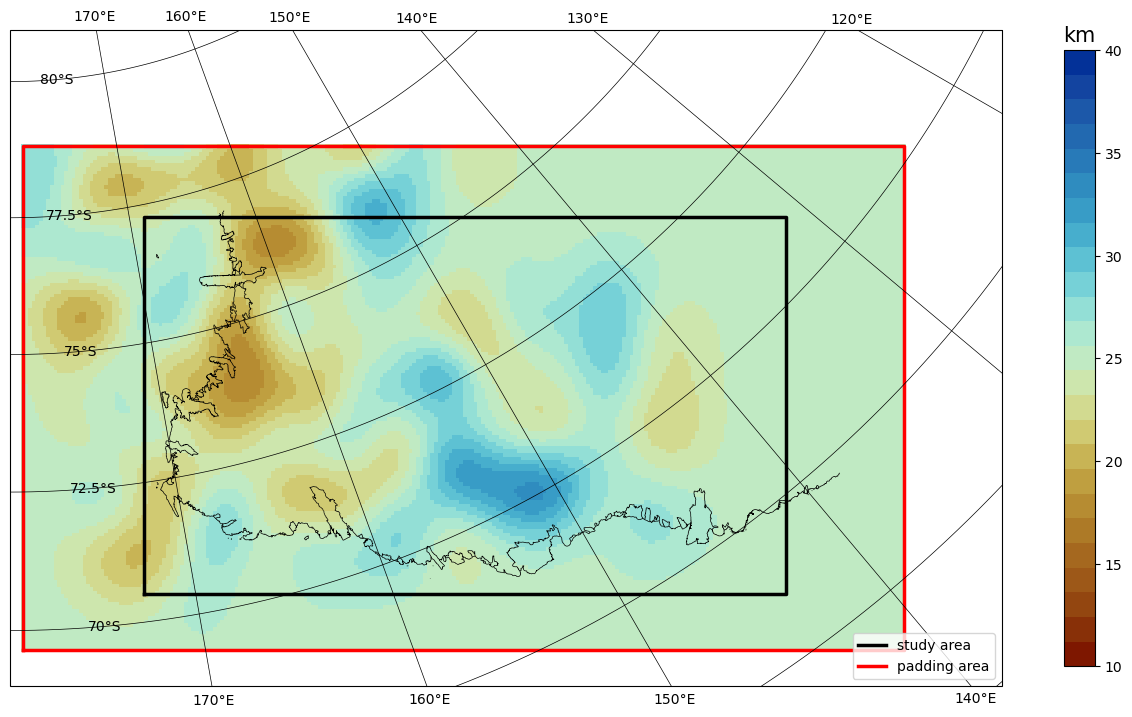

In [34]:
figure1 = plt.figure(figsize=(16,10),facecolor='white')

ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

im1 = plt.pcolor(xq-(2*x_shift),yq-(2*y_shift),CDP_kriged/1000, cmap=cmap , vmin=10 , vmax=40)
plt.plot(poly_x,poly_y,'k' , linewidth=2.5,label='study area') 
plt.plot(poly_pad_x,poly_pad_y,'r' , linewidth=2.5,label='padding area') 
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
cb = plt.colorbar(im1, pad=0.05 , shrink=.80)
cb.ax.set_title("km",fontsize=15)
ax1.legend(loc='lower right')
ax1.set_extent([180 , 120 , -72, -69], ccrs.PlateCarree())

# figure1.savefig('CDP_kriged_20nlag.png',format='png',dpi=500)

#### Substitute Moho depth values where CDP is below Moho

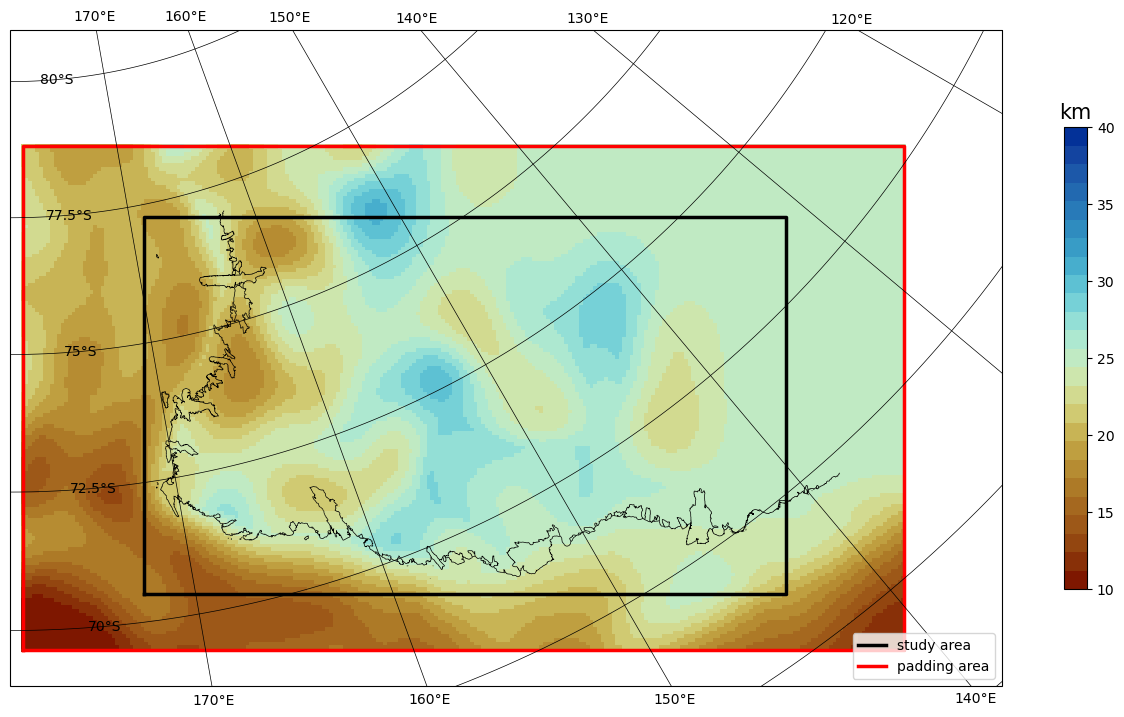

In [35]:
CDP_Moho_diff = CDP_kriged - Moho_mesh_grd
CDP_flat = CDP_kriged.flatten()
Moho_flat = Moho_mesh_grd.flatten()
CDP_Moho_diff_flat = CDP_Moho_diff.flatten()


CDP_above_Moho = np.zeros(len(CDP_flat))

for i in range(len(CDP_flat)):
    if CDP_Moho_diff_flat[i] > 0 :
        CDP_above_Moho[i] = Moho_flat[i]
    else:
         CDP_above_Moho[i] = CDP_flat[i]

            
CDP_above_Moho_grd = CDP_above_Moho.reshape((len(Grid_Y),len(Grid_X)))

figure1 = plt.figure(figsize=(16,10),facecolor='white')
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

im1 = plt.pcolor(xq-(2*x_shift),yq-(2*y_shift),CDP_above_Moho_grd/1000, cmap=cmap , vmin=10 , vmax=40)
plt.plot(poly_x,poly_y,'k' , linewidth=2.5,label='study area') 
plt.plot(poly_pad_x,poly_pad_y,'r' , linewidth=2.5, label='padding area') 
Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
ax1.gridlines(linewidth=0.5,draw_labels=True , color='k', alpha=1, linestyle='-' , rotate_labels=0)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, pad=0.05 , shrink=.60)
cb.ax.set_title("km",fontsize=15)
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)
ax1.legend(loc='lower right')
ax1.set_extent([180 , 120 , -72, -69], ccrs.PlateCarree())


# figure1.savefig('CDP_above_Moho.png', format='png',dpi=500)

#### export merged CDP and Moho depth

In [36]:
export_CDP_depth4profile = np.vstack([xq.flatten(),yq.flatten(),CDP_above_Moho_grd.flatten()]).T
np.savetxt('DATA/CDP_depth4profile.txt', export_CDP_depth4profile, delimiter=',' , header='x,y,CDP')

export_Moho_depth4profile =  np.vstack([xq.flatten(),yq.flatten(),Moho_mesh_grd.flatten()]).T
np.savetxt('DATA/Moho_depth4profile.txt', export_Moho_depth4profile, delimiter=',' , header='x,y,Moho')

export_Topo_depth4profile =  np.vstack([xq.flatten(),yq.flatten(),topo_mesh_grd.flatten()]).T
np.savetxt('DATA/Topo_depth4profile.txt', export_Topo_depth4profile, delimiter=',' , header='x,y,Topo')

#### reshape input data grids and export them

In [37]:
#coordinates
cell_boundaries = np.vstack((xq.flatten() , yq.flatten())).T

# Moho grid
Moho_values_regridded = np.vstack((xq.flatten() , yq.flatten() , Moho_mesh_grd.flatten())).T

# Topo grid
Topo_values_regridded = np.vstack((xq.flatten() , yq.flatten() , topo_mesh_grd.flatten())).T

## CDP above Moho
CDP_above_Moho_regridded = np.vstack((xq.flatten() , yq.flatten() , CDP_above_Moho_grd.flatten())).T


np.savetxt('DATA/exported_Topo_values_regridded.txt', Topo_values_regridded, delimiter=',' , header='x,y,z')
np.savetxt('DATA/exported_CDP_above_Moho_regridded.txt', CDP_above_Moho_regridded, delimiter=',' , header='x,y,z')

## Build density  covariacne mesh 
Assign every cell a value of 1 or close to zero (1e-20). A value of 1 means that this cell can freely vary in the inversion and that the cell is between topography and Moho/CDP. A value of 1e-20 means that the cell is kept fix in the inversion and that the cell is either above the topography or below the Moho/CDP.

In [38]:
dens_index_total_mesh = []

for j in range(nz):  
    
    # define depth inverval
    lower_cell_boundary_index = Depth[j]  # depth against each bottom cell boundary is tested against
    
    # create empty temporary variable 
    index_matrix_temp = np.zeros(len(cell_boundaries[:,0]))

    for i in range(len(Topo_values_regridded[:,0])):
        
        if Topo_values_regridded[i,2] > lower_cell_boundary_index or Moho_values_regridded[i,2] < lower_cell_boundary_index:
            index_matrix_temp[i] = 1e-20
        else:
            index_matrix_temp[i] = 1
            
        index_grd = index_matrix_temp.reshape((len(Grid_Y),len(Grid_X)))
        
    dens_index_total_mesh.append(index_grd)
    
dens_cov_total_mesh = np.array(dens_index_total_mesh)
dens_cov_total_mesh.shape


(21, 140, 244)

#### plot Air Rock index

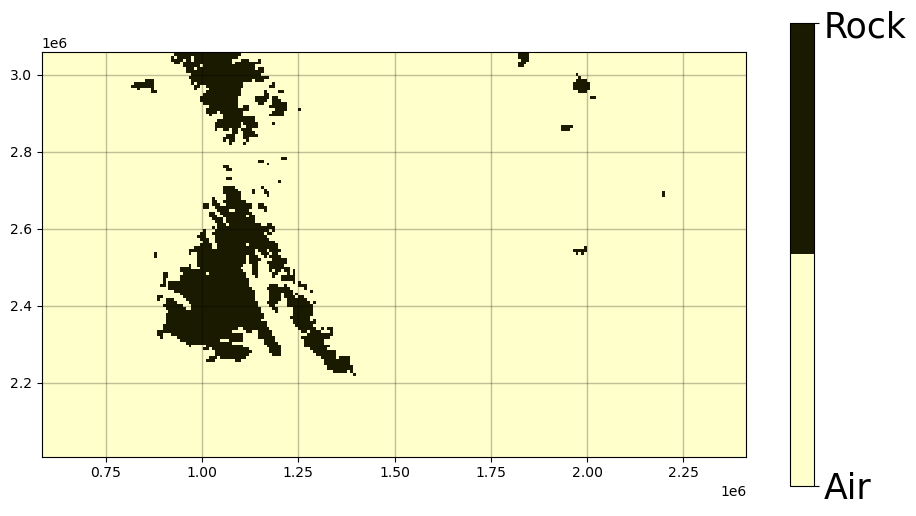

In [39]:
# define colorbar for air rock index
ar_ix_cmap = cm.lajolla.resampled(2)

# create figure
figure1 = plt.figure(figsize=(25,20))

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1)

im1 = plt.pcolor(xq , yq , dens_cov_total_mesh[2,:,:] , cmap=ar_ix_cmap)


axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, pad=0.05 , shrink=.3)
cb.set_ticks([0,1])
cb.set_ticklabels(["Air", "Rock"])
im1.figure.axes[1].tick_params(axis="y", labelsize=25) # increase label size of the colorbar
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)


## Build NetCDF for density covariance index (dens_cov)


In [40]:
model_density_cov = Dataset(inversion_path + "density_cov.nc", "w")
Grid_x_dim = model_density_cov.createDimension("Northing", Grid_X.size)
Grid_y_dim = model_density_cov.createDimension("Easting", Grid_Y.size)
Depthdim = model_density_cov.createDimension("Depth", Depth.size)
bgdim = model_density_cov.createDimension("bg_layers", bg_densities.size)
         
v_x_direction = model_density_cov.createVariable("Northing","f8",("Northing"))
v_x_direction[:] = Grid_X[:]
v_x_direction.units = "m"

v_x_direction_orig = model_density_cov.createVariable("Northing_Origin","f8")
v_x_direction_orig[:] = startx
         
v_y_direction = model_density_cov.createVariable("Easting","f8",("Easting"))
v_y_direction[:] = Grid_Y[:]
v_y_direction.units = "m"
v_y_direction_orig = model_density_cov.createVariable("Easting_Origin","f8")
v_y_direction_orig[:] = starty
         
vdepth = model_density_cov.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_density_cov.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens_cov  = model_density_cov.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens_cov[:,:,:] = dens_cov_total_mesh[:,:,:]
vdens_cov.units = "kg/m3"

vdensthick = model_density_cov.createVariable("bg_thicknesses","f8",("bg_layers"))
vdensthick[:] = bg_dens_thickness[:]
vdensthick.units = "m"

model_density_cov.close()  

## Build susceptibility  covariacne mesh 
Assign every covariance cell in every depth intervall 1 or close 0. 1 = cell can freely vary and that the cell is not above topography or below Moho. Near to 0 = cell is kept fix and indicates that the cell is either air or below the Moho interface

In [41]:
sus_index_total_mesh = []

for j in range(nz):  
    
    # define depth inverval
    lower_cell_boundary_index = Depth[j]  # depth against each bottom cell boundary is tested against
    
    # create empty temporary variable 
    index_matrix_temp = np.zeros(len(cell_boundaries[:,0]))

    for i in range(len(Topo_values_regridded[:,0])):
        
        if Topo_values_regridded[i,2] > lower_cell_boundary_index or CDP_above_Moho_regridded[i,2] < lower_cell_boundary_index:
            index_matrix_temp[i] = 1e-20
        else:
            index_matrix_temp[i] = 1
            
        index_grd = index_matrix_temp.reshape((len(Grid_Y),len(Grid_X)))
        
    sus_index_total_mesh.append(index_grd)
    
sus_cov_total_mesh = np.array(sus_index_total_mesh)
sus_cov_total_mesh.shape


(21, 140, 244)

## Build NetCDF for Susceptibility covariance index (sus_cov)


In [42]:
model_sus_cov = Dataset(inversion_path + "Susceptibility_cov.nc", "w")
Grid_x_dim = model_sus_cov.createDimension("Northing", Grid_X.size)
Grid_y_dim = model_sus_cov.createDimension("Easting", Grid_Y.size)
Depthdim = model_sus_cov.createDimension("Depth", Depth.size)
bgdim = model_sus_cov.createDimension("bg_layers", bg_densities.size)
         
v_x_direction = model_sus_cov.createVariable("Northing","f8",("Northing"))
v_x_direction[:] = Grid_X[:]
v_x_direction.units = "m"

v_x_direction_orig = model_sus_cov.createVariable("Northing_Origin","f8")
v_x_direction_orig[:] = startx
         
v_y_direction = model_sus_cov.createVariable("Easting","f8",("Easting"))
v_y_direction[:] = Grid_Y[:]
v_y_direction.units = "m"
v_y_direction_orig = model_sus_cov.createVariable("Easting_Origin","f8")
v_y_direction_orig[:] = starty
         
vdepth = model_sus_cov.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_sus_cov.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens_cov  = model_sus_cov.createVariable("Susceptibility","f8",("Depth","Easting","Northing"))
vdens_cov[:,:,:] = sus_cov_total_mesh[:,:,:]
vdens_cov.units = " "

vdensthick = model_sus_cov.createVariable("bg_thicknesses","f8",("bg_layers"))
vdensthick[:] = bg_dens_thickness[:]
vdensthick.units = "m"

model_sus_cov.close()  

## Build MI covariance index mesh (which cells are used in MI or gravity only inversion)

In [43]:
MI_covar_mesh = []

for j in range(nz):  
    
    # define depth inverval
    lower_cell_boundary_index = Depth[j]  # depth against each bottom cell boundary is tested against
    
    # create empty temporary variable 
    ix_matrix_temp = np.zeros(len(cell_boundaries[:,0]))

    for i in range(len(Topo_values_regridded[:,0])):
        
        if  Topo_values_regridded[i,2] > lower_cell_boundary_index or CDP_above_Moho_regridded[i,2] < lower_cell_boundary_index:
            ix_matrix_temp[i] = 0
        else:
            ix_matrix_temp[i] = 1
            
        ix_grd = ix_matrix_temp.reshape((len(Grid_Y),len(Grid_X)))
        
    MI_covar_mesh.append(ix_grd)
    
MI_cov_total_mesh = np.array(MI_covar_mesh)
MI_cov_total_mesh.shape


(21, 140, 244)

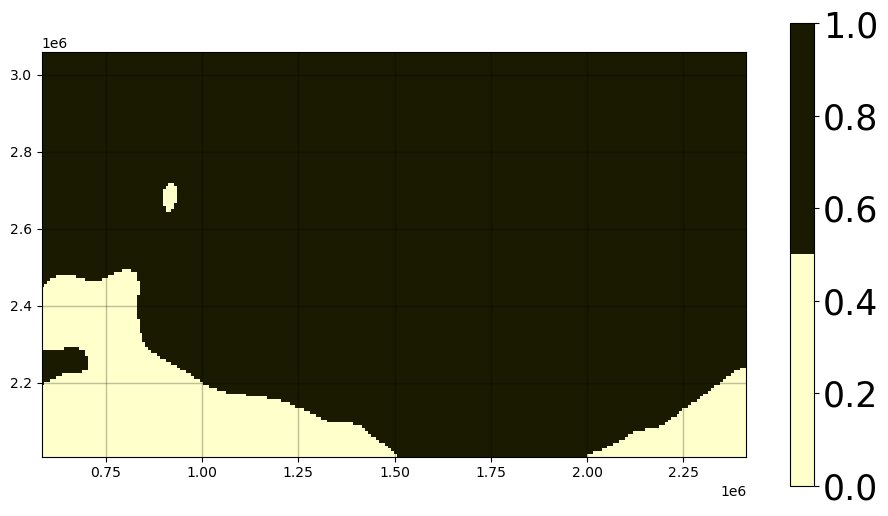

In [44]:
# define colorbar for air rock index
ar_ix_cmap = cm.lajolla.resampled(2)

# create figure
figure1 = plt.figure(figsize=(25,20))

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1)

im1 = plt.pcolor(xq , yq , MI_cov_total_mesh[11,:,:] , cmap=ar_ix_cmap)


axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, pad=0.05 , shrink=.3)
# cb.set_ticks([0,1])
# cb.set_ticklabels(["Air", "Rock"])
im1.figure.axes[1].tick_params(axis="y", labelsize=25) # increase label size of the colorbar
plt.grid(color='k', linestyle='-', linewidth=1 , alpha=.25)


## Build NetCDF for MI covariance index (MI_covar)


In [45]:
model_MI_cov = Dataset(inversion_path + "MI_cov.nc", "w")
Grid_x_dim = model_MI_cov.createDimension("Northing", Grid_X.size)
Grid_y_dim = model_MI_cov.createDimension("Easting", Grid_Y.size)
Depthdim = model_MI_cov.createDimension("Depth", Depth.size)
bgdim = model_MI_cov.createDimension("bg_layers", bg_densities.size)
         
v_x_direction = model_MI_cov.createVariable("Northing","f8",("Northing"))
v_x_direction[:] = Grid_X[:]
v_x_direction.units = "m"

v_x_direction_orig = model_MI_cov.createVariable("Northing_Origin","f8")
v_x_direction_orig[:] = startx
         
v_y_direction = model_MI_cov.createVariable("Easting","f8",("Easting"))
v_y_direction[:] = Grid_Y[:]
v_y_direction.units = "m"
v_y_direction_orig = model_MI_cov.createVariable("Easting_Origin","f8")
v_y_direction_orig[:] = starty
         
vdepth = model_MI_cov.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_MI_cov.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens_cov  = model_MI_cov.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens_cov[:,:,:] = MI_cov_total_mesh[:,:,:]
vdens_cov.units = "kg/m3"

vdensthick = model_MI_cov.createVariable("bg_thicknesses","f8",("bg_layers"))
vdensthick[:] = bg_dens_thickness[:]
vdensthick.units = "m"

model_MI_cov.close()  

### Checking / plot NetCDF files  (sanity check)

In [46]:
cmap = cm.roma.resampled(25)
cmap_rev = cm.roma_r.resampled(25)

## load grav data
grav_data_nc = nc4.Dataset(inversion_path + 'gravdata.nc') 
XX_grav = grav_data_nc.variables['MeasPosX'][:]
YY_grav = grav_data_nc.variables['MeasPosY'][:]
grav_data = grav_data_nc.variables['Scalar_gravity'][:]

## load grav mesh
grav_mesh_nc = nc4.Dataset(inversion_path + 'start_grav.nc') 
XX_grav_mesh = grav_mesh_nc.variables['Northing'][:]
YY_grav_mesh = grav_mesh_nc.variables['Easting'][:]
bg_grav_mesh = grav_mesh_nc.variables['Density'][:]

## load grav cov mesh
grav_cov_mesh_nc = nc4.Dataset(inversion_path + 'density_cov.nc') 
XX_grav_cov_mesh = grav_cov_mesh_nc.variables['Northing'][:]
YY_grav_cov_mesh = grav_cov_mesh_nc.variables['Easting'][:]
cov_mesh = grav_cov_mesh_nc.variables['Density'][:]


## load mag data
mag_data_nc = nc4.Dataset(inversion_path + 'magdata.nc') 
XX_mag = mag_data_nc.variables['MeasPosX'][:]
YY_mag = mag_data_nc.variables['MeasPosY'][:]
mag_data = mag_data_nc.variables['T'][:]

## load mag mesh
mag_mesh_nc = nc4.Dataset(inversion_path + 'start_mag.nc') 
XX_mag_mesh = mag_mesh_nc.variables['Northing'][:]
YY_mag_mesh = mag_mesh_nc.variables['Easting'][:]
bg_mag_mesh = mag_mesh_nc.variables['Susceptibility'][:]

## load grav cov mesh
sus_cov_mesh_nc = nc4.Dataset(inversion_path + 'Susceptibility_cov.nc') 
XX_sus_cov_mesh = sus_cov_mesh_nc.variables['Northing'][:]
YY_sus_cov_mesh = sus_cov_mesh_nc.variables['Easting'][:]
cov_sus = sus_cov_mesh_nc.variables['Susceptibility'][:]



grav_data_nc.close()
grav_mesh_nc.close()
grav_cov_mesh_nc.close()
mag_data_nc.close()
mag_mesh_nc.close()
sus_cov_mesh_nc.close()


Text(0.5, 1.0, 'nT')

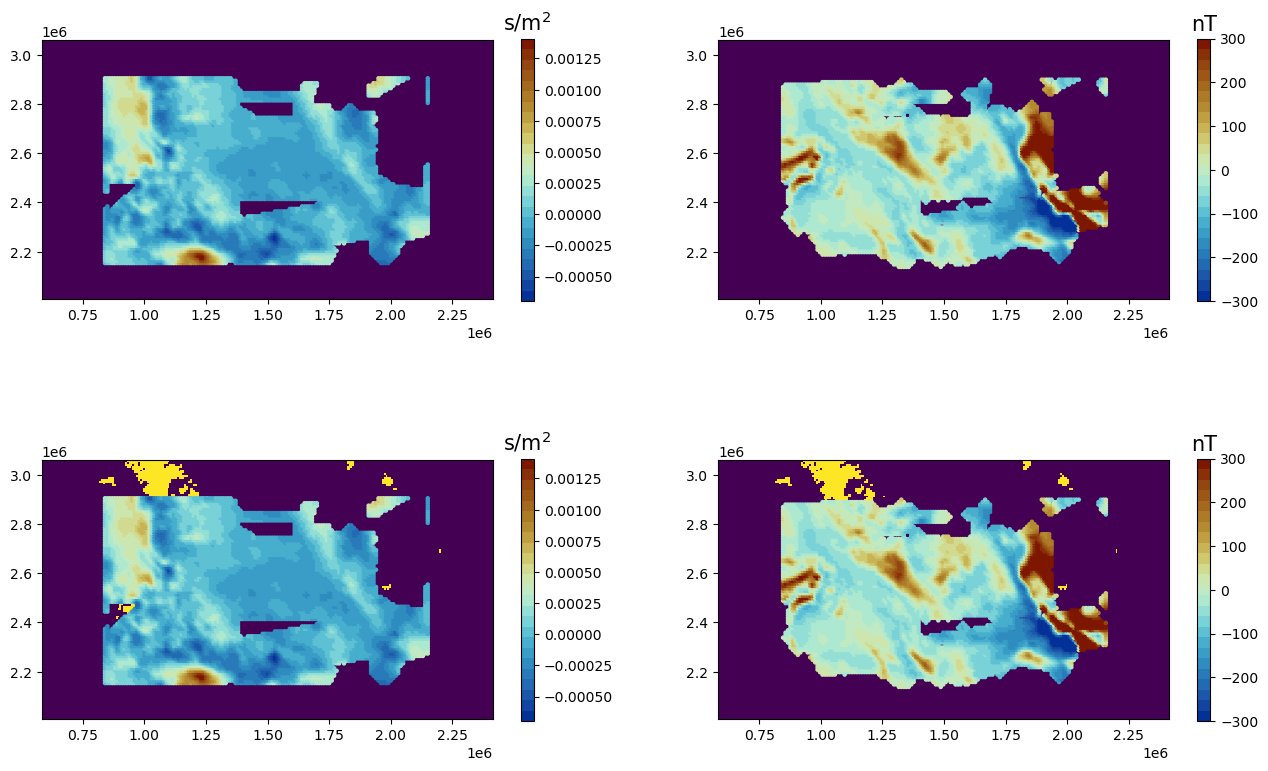

In [47]:
xq_grav , yq_grav = np.meshgrid(XX_grav_mesh , YY_grav_mesh)   
xq_mag , yq_mag = np.meshgrid(XX_mag_mesh , YY_mag_mesh)   
xq_grav_cov , yq_grav_cov = np.meshgrid(XX_grav_cov_mesh , YY_grav_cov_mesh)
xq_sus_cov , yq_sus_cov = np.meshgrid(XX_sus_cov_mesh , YY_sus_cov_mesh)

figure1 = plt.figure(figsize=(16,10)) 
ax1 = plt.subplot(2 , 2 , 1)
plt.pcolormesh(xq_grav , yq_grav , bg_grav_mesh[0,:,:])  # plotting
im = plt.scatter( XX_grav , YY_grav , 5 , c=grav_data , cmap=cmap_rev )
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=.75)
cb.ax.set_title("s/m$^{2}$",fontsize=15)

ax2 = plt.subplot(2 , 2 , 2)
plt.pcolormesh(xq_mag , yq_mag , bg_mag_mesh[0,:,:])  # plotting
im = plt.scatter( XX_mag , YY_mag , 5 , c=mag_data , cmap=cmap_rev , vmin = -300 , vmax = 300)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=.75)
cb.ax.set_title("nT",fontsize=15)


ax3 = plt.subplot(2 , 2 , 3)
im3 = plt.pcolormesh(xq_grav_cov,yq_grav_cov,cov_mesh[2,:,:])
im = plt.scatter( XX_grav , YY_grav , 5 , c=grav_data , cmap=cmap_rev )
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=.75)
cb.ax.set_title("s/m$^{2}$",fontsize=15)


ax4 = plt.subplot(2 , 2 , 4)
im4 = plt.pcolormesh(xq_sus_cov,yq_sus_cov,cov_sus[2,:,:])
im = plt.scatter( XX_mag , YY_mag , 5 , c=mag_data , cmap=cmap_rev , vmin = -300 , vmax = 300)
axes=plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=.75)
cb.ax.set_title("nT",fontsize=15)


## Creat inversion run files

#### Mutal information inversion (joint inversion)

In [48]:
#location of the jif3D executables on your system
execpath = "../../../bin/"
#program we want to run
progname = "jointinv"
options = " --inclination -1.47 --declination 2.57 --fieldstrength 64981 --mutual_information 100 --scalminerr 2e-5 --magminerr 15 --mindens -250 --maxdens 250 --minsus -0.1 --maxsus 0.1 --dens_covmod density_cov.nc --sus_covmod Susceptibility_cov.nc --coupling_validity MI_cov.nc "
#name of the density starting mesh
gravmesh = "start_grav.nc"
#name of the gravity data file
gravdata = "gravdata.nc"
#name of the susecptibility starting mesh
magmesh = "start_mag.nc"
#name of the magnetics data file
magdata = "magdata.nc"

## set data weights. 0 means no data

# gravity data
gravweight = 1.0
# FTG data 
ftgweight = 0.0
# magnetic data
magweight = 1.0
magvectorweight = 0.0
mtweight = 0.0
DCResistivity = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
# coupling term
coupling = 15e3
# density regularization
gravregularization = 10.0
# susceptibility regularization
magregularization = 10.0
#maximum number of iterations
iterations = 100

#write all information to file
f = open( inversion_path +'run', 'w')
f.write(execpath+progname+options+" <<eof \n")    
f.write(magmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(magdata+"\n")
f.write(magmesh+"\n")
f.write(str(magvectorweight)+"\n")
f.write(str(mtweight)+"\n")
f.write(str(DCResistivity)+"\n")
f.write(str(tomographyweight)+"\n")
f.write(str(surfacewaveweight)+"\n")
f.write(str(coupling)+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

#### gravity only inversion run file

In [49]:
# #location of the jif3D executables on your system
# execpath = "../../../bin/"
# #program we want to run
# progname = "jointinv"
# options = "-- scalminerr 2e-5 --mindens -200 --maxdens 200 --stochcov 1 --dens_covmod density_cov.nc "
# #name of the density starting mesh
# gravmesh = "start_grav.nc"
# #name of the gravity data file
# gravdata = "gravdata.nc"
# #name of the susecptibility starting mesh
# magmesh = "start_mag.nc"
# #name of the magnetics data file
# magdata = "magdata.nc"

# ## set data weights. 0 means no data

# # gravity data
# gravweight = 1.0
# # FTG data 
# ftgweight = 0.0
# # magnetic data
# magweight = 0.0
# magvectorweight = 0.0
# mtweight = 0.0
# DCResistivity = 0.0
# tomographyweight = 0.0
# surfacewaveweight = 0.0
# # coupling term
# coupling = 0
# # density regularization
# gravregularization = 1.0
# # susceptibility regularization
# magregularization = 1.0
# #maximum number of iterations
# iterations = 100.0

# #write all information to file
# f = open( inversion_path +'run', 'w')
# f.write(execpath+progname+options+" <<eof \n")    
# f.write(magmesh+"\n")
# f.write(str(gravweight)+"\n")
# f.write(str(ftgweight)+"\n")
# f.write(gravdata+"\n")
# f.write(gravmesh+"\n")
# f.write(str(magweight)+"\n")
# f.write(magdata+"\n")
# f.write(magmesh+"\n")
# f.write(str(magvectorweight)+"\n")
# f.write(str(mtweight)+"\n")
# f.write(str(DCResistivity)+"\n")
# f.write(str(tomographyweight)+"\n")
# f.write(str(surfacewaveweight)+"\n")
# f.write(str(coupling)+"\n")
# f.write(str(gravregularization)+"\n")
# f.write(str(magregularization)+"\n")
# f.write(str(iterations)+"\n")
# f.write("eof\n")
# f.close()

#### magnetic only inversion run file

In [50]:
# #location of the jif3D executables on your system
# execpath = "../../../bin/"
# #program we want to run
# progname = "jointinv"
# options = " --inclination -1.47 --declination 2.57 --fieldstrength 64981 --magminerr 15 --minsus -0.1 --maxsus 0.1 --stochcov 1 --sus_covmod Susceptibility_cov.nc"
# #name of the density starting mesh
# gravmesh = "start_grav.nc"
# #name of the gravity data file
# gravdata = "gravdata.nc"
# #name of the susecptibility starting mesh
# magmesh = "start_mag.nc"
# #name of the magnetics data file
# magdata = "magdata.nc"

# ## set data weights. 0 means no data

# # gravity data
# gravweight = 0.0
# # FTG data 
# ftgweight = 0.0
# # magnetic data
# magweight = 1.0
# magvectorweight = 0.0
# mtweight = 0.0
# DCResistivity = 0.0
# tomographyweight = 0.0
# surfacewaveweight = 0.0
# # coupling term
# coupling = 0
# # density regularization
# gravregularization = 1.0
# # susceptibility regularization
# magregularization = 1.0
# #maximum number of iterations
# iterations = 100.0

# #write all information to file
# f = open( inversion_path +'run', 'w')
# f.write(execpath+progname+options+" <<eof \n")    
# f.write(magmesh+"\n")
# f.write(str(gravweight)+"\n")
# f.write(str(ftgweight)+"\n")
# f.write(gravdata+"\n")
# f.write(gravmesh+"\n")
# f.write(str(magweight)+"\n")
# f.write(magdata+"\n")
# f.write(magmesh+"\n")
# f.write(str(magvectorweight)+"\n")
# f.write(str(mtweight)+"\n")
# f.write(str(DCResistivity)+"\n")
# f.write(str(tomographyweight)+"\n")
# f.write(str(surfacewaveweight)+"\n")
# f.write(str(coupling)+"\n")
# f.write(str(gravregularization)+"\n")
# f.write(str(magregularization)+"\n")
# f.write(str(iterations)+"\n")
# f.write("eof\n")
# f.close()

## prepare second VI inversion with a lower coupling

In [51]:
previous_inversion = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_25e3_run1'

Inversion_run = 'VI_inversion_shifted_AntGG_residual_grav_gravmag_reg10_coupling_15e3_run2'

# Create path if it does not exists
if not os.path.exists(Inversion_run):
    os.makedirs(Inversion_run)

inversion_path = Inversion_run + '/VI_inversion/'

# Create path if it does not exists
if not os.path.exists(inversion_path):
    os.makedirs(inversion_path)

In [52]:
## load grav data
G1 = nc4.Dataset(previous_inversion + '/VI_inversion/result99.grav.inv.nc') 
G2 = nc4.Dataset(previous_inversion + '/VI_inversion/result99.mag.inv.nc') 

inv_dens = G1.variables['Density'][:]
bg_densities = G1.variables['bg_densities'][:]
bg_thickness = G1.variables['bg_thicknesses'][:]


inv_sus = G2.variables['Susceptibility'][:]

G1.close
G2.close

<function Dataset.close>

In [53]:
#read in geometry of gravity inversion mesh
grav_fh = Dataset(previous_inversion + "/VI_inversion/start_grav.nc", "r")
GNo = grav_fh.variables["Northing_Origin"][:]
GEo = grav_fh.variables["Easting_Origin"][:]
GDo = grav_fh.variables["Depth_Origin"][:]
Northing = grav_fh.variables["Northing"][:]
Easting = grav_fh.variables["Easting"][:]
Depth = grav_fh.variables["Depth"][:]
grav_fh.close()
#Create a 3D array for susceptibility filled with zero.
nx = Northing.size
ny = Easting.size
nz = Depth.size

grav_fh.close

<function Dataset.close>

In [54]:
model_grav = Dataset(inversion_path +"start_grav2.nc", "w")
Northdim = model_grav.createDimension("Northing", Northing.size)
Eastdim = model_grav.createDimension("Easting", Easting.size)
Depthdim = model_grav.createDimension("Depth", Depth.size)
bgdim = model_grav.createDimension("bg_layers", bg_densities.size)
         
v_x_direction = model_grav.createVariable("Northing","f8",("Northing"))
v_x_direction[:] = Northing[:]
v_x_direction.units = "m"

v_x_direction_orig = model_grav.createVariable("Northing_Origin","f8")
v_x_direction_orig[:] = GNo
         
v_y_direction = model_grav.createVariable("Easting","f8",("Easting"))
v_y_direction[:] = Easting[:]
v_y_direction.units = "m"
v_y_direction_orig = model_grav.createVariable("Easting_Origin","f8")
v_y_direction_orig[:] = GEo
         
vdepth = model_grav.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_grav.createVariable("Depth_Origin","f8")
vdepth_orig[:] = GDo
         
vdens  = model_grav.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens[:,:,:] = inv_dens[:,:,:]
vdens.units = "kg/m3"
         
vbgdens = model_grav.createVariable("bg_densities","f8",("bg_layers"))
vbgdens[:] = bg_densities[:]
vbgdens.units = "kg/m3"
         
vbgthick = model_grav.createVariable("bg_thicknesses","f8",("bg_layers"))
vbgthick[:] = bg_thickness[:]
vbgthick.units = "m"

model_grav.close()  

In [55]:
model_fh = Dataset(inversion_path + "start_mag2.nc", "w")
Northdim = model_fh.createDimension("Northing", Northing.size)
Eastdim = model_fh.createDimension("Easting", Easting.size)
Depthdim = model_fh.createDimension("Depth", Depth.size)
         
vnorth = model_fh.createVariable("Northing","f8",("Northing"))
vnorth[:] = Northing[:]
vnorth.units = "m"

vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
vnorth_orig[:] = GNo
         
veast = model_fh.createVariable("Easting","f8",("Easting"))
veast[:] = Easting[:]
veast.units = "m"
veast_orig = model_fh.createVariable("Easting_Origin","f8")
veast_orig[:] = GEo
         
vdepth = model_fh.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
vdepth_orig[:] = GDo
         
vsus  = model_fh.createVariable("Susceptibility","f8",("Depth","Easting","Northing"))
vsus[:,:,:] = inv_sus[:,:,:]
vsus.units = " "
model_fh.close()  

In [56]:
#location of the jif3D executables on your system
execpath = "../../../bin/"
#program we want to run
progname = "jointinv"
options = " --inclination -1.47 --declination 2.57 --fieldstrength 64981 --mutual_information 100 --scalminerr 2e-5 --magminerr 15 --mindens -250 --maxdens 250 --minsus -0.1 --maxsus 0.1 --dens_covmod density_cov.nc --sus_covmod Susceptibility_cov.nc --coupling_validity MI_cov.nc "
#name of the density starting mesh
gravmesh = "start_grav.nc"
#name of the gravity data file
gravdata = "gravdata.nc"
#name of the susecptibility starting mesh
magmesh = "start_mag.nc"
#name of the magnetics data file
magdata = "magdata.nc"

## set data weights. 0 means no data

# gravity data
gravweight = 1.0
# FTG data 
ftgweight = 0.0
# magnetic data
magweight = 1.0
magvectorweight = 0.0
mtweight = 0.0
DCResistivity = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
# coupling term
coupling = 15e3
# density regularization
gravregularization = 10.0
# susceptibility regularization
magregularization = 10.0
#maximum number of iterations
iterations = 25.0

#write all information to file
f = open( inversion_path +'run2', 'w')
f.write(execpath+progname+options+" <<eof \n")    
f.write(magmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(magdata+"\n")
f.write(magmesh+"\n")
f.write(str(magvectorweight)+"\n")
f.write(str(mtweight)+"\n")
f.write(str(DCResistivity)+"\n")
f.write(str(tomographyweight)+"\n")
f.write(str(surfacewaveweight)+"\n")
f.write(str(coupling)+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()